<h1 div class='alert alert-success'><center> TPS-Set: ponto de partida (EDA, linha de base)</center></h1>

![](https://storage.googleapis.com/kaggle-competitions/kaggle/26480/logos/header.png?t=2021-04-09-00-57-05)

# Descrição de dados

Para esta competição, você vai prever se um cliente fez uma reclamação sobre uma apólice de seguro. A verdade fundamental claimtem valor binário, mas uma previsão pode ser qualquer número de 0.0 para 1.0, representando a probabilidade de uma reclamação. Os recursos neste conjunto de dados foram tornados anônimos e podem conter valores ausentes.
arquivos

- `train.csv`: os dados de treinamento com o alvo claimcoluna
- `test.csv`: o conjunto de teste; você estará prevendo o claimpara cada linha neste arquivo
- `sample_submission.csv`:  um arquivo de envio de amostra no formato correto


# <div class="alert alert-success">  0. IMPORTAÇÕES </div> 


In [67]:
import warnings
import random
import os
import gc

In [68]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt 
import seaborn           as sns
import joblib            as jb

In [69]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt 
import seaborn           as sns
import joblib            as jb
import matplotlib.pyplot as plt

In [109]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing   import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, QuantileTransformer
from sklearn.impute          import SimpleImputer
from sklearn                 import metrics

In [71]:
import xgboost               as xgb

## 0.2. Funções
Aqui centralizamos todas as funções desenvolvidas durante o projeto para melhor organização do código.

In [72]:
def jupyter_setting():
    
    %matplotlib inline
      
    #os.environ["WANDB_SILENT"] = "true" 
    #plt.style.use('bmh') 
    #plt.rcParams['figure.figsize'] = [20,15]
    #plt.rcParams['font.size']      = 13
     
    pd.options.display.max_columns = None
    #pd.set_option('display.expand_frame_repr', False)

    warnings.filterwarnings(action='ignore')
    warnings.simplefilter('ignore')
    warnings.filterwarnings('ignore')
    #warnings.filterwarnings(category=UserWarning)
    
    pd.set_option('display.max_rows', 150)
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.max_colwidth', None)

    icecream = ["#00008b", "#960018","#008b00", "#00468b", "#8b4500", "#582c00"]
    #sns.palplot(sns.color_palette(icecream))
    
    return icecream

icecream = jupyter_setting()

warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
#warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

# Colors
dark_red = "#b20710"
black    = "#221f1f"
green    = "#009473"
myred    = '#CD5C5C'
myblue   = '#6495ED'
mygreen  = '#90EE90'

cols= [myred, myblue,mygreen]

In [73]:
colors = ["lightcoral", "sandybrown", "darkorange", "mediumseagreen",
          "lightseagreen", "cornflowerblue", "mediumpurple", "palevioletred",
          "lightskyblue", "sandybrown", "yellowgreen", "indianred",
          "lightsteelblue", "mediumorchid", "deepskyblue"]

In [74]:
def missing_zero_values_table(df):
        mis_val         = df.isnull().sum()
        mis_val_percent = round(df.isnull().mean().mul(100), 2)
        mz_table        = pd.concat([mis_val, mis_val_percent], axis=1)
        mz_table        = mz_table.rename(columns = {df.index.name:'col_name', 
                                                     0 : 'Valores ausentes', 
                                                     1 : '% de valores totais'})
        
        mz_table['Tipo de dados'] = df.dtypes
        mz_table                  = mz_table[mz_table.iloc[:,1] != 0 ]. \
                                     sort_values('% de valores totais', ascending=False)
        
        msg = "Seu dataframe selecionado tem {} colunas e {} " + \
              "linhas. \nExistem {} colunas com valores ausentes."
            
        print (msg.format(df.shape[1], df.shape[0], mz_table.shape[0]))
        
        return mz_table.reset_index()

In [75]:
def describe(df):
    var = df.columns

    # Medidas de tendência central, média e mediana 
    ct1 = pd.DataFrame(df[var].apply(np.mean)).T
    ct2 = pd.DataFrame(df[var].apply(np.median)).T

    # Dispensão - str, min , max range skew, kurtosis
    d1 = pd.DataFrame(df[var].apply(np.std)).T
    d2 = pd.DataFrame(df[var].apply(min)).T
    d3 = pd.DataFrame(df[var].apply(max)).T
    d4 = pd.DataFrame(df[var].apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(df[var].apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(df[var].apply(lambda x: x.kurtosis())).T
    d7 = pd.DataFrame(df[var].apply(lambda x: (3 *( np.mean(x) - np.median(x)) / np.std(x) ))).T

    # concatenete 
    m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6, d7]).T.reset_index()
    m.columns = ['attrobutes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis','coef_as']
    
    return m

In [76]:
def graf_bar_churn(df, col, title, xlabel, ylabel, tol = 0):
    
    #ax    = df.groupby(['churn_cat'])['churn_cat'].count()
    ax     = df    
    colors = cols
    
    if tol == 0: 
        total  = sum(ax)
        ax = (ax).plot(kind    ='bar',
                   stacked = True,
                    width = .5,
                   rot     = 0,
                   color   = colors)
    else:
        total  = tol     
        
        ax = (ax).plot(kind    ='bar',
                       stacked = True,
                       width = .5,
                       rot     = 0,figsize = (10,6),
                       color   = colors)

    #ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    
    #y_fmt = tick.FormatStrFormatter('%.0f') 
    #ax.yaxis.set_major_formatter(y_fmt)

    title   = title + ' \n'
    xlabel  = '\n ' + xlabel 
    ylabel  = ylabel + ' \n'
    
    ax.set_title(title  , fontsize=22)
    ax.set_xlabel(xlabel, fontsize=13)
    ax.set_ylabel(ylabel, fontsize=13)    

    min = [0,23000000]
    #ax.set_ylim(min)
    
    for i in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        width, height = i.get_width(), i.get_height()
        x, y = i.get_xy()        
        
        ax.annotate(str(round((i.get_height() * 100.0 / total), 1) )+'%', 
                    (i.get_x()+.3*width, 
                     i.get_y()+.5*height),
                     color   = 'white',
                     weight = 'bold',
                     size   = 14)

## 0.3. Carregar Dados
Existem 2 conjuntos de dados que são usados na análise, eles são o conjunto de dados de treinamento e de teste. O principal uso do conjunto de dados de treino é treinar os modelos e usá-lo para prever o conjunto de dados de teste. 

Enquanto o arquivo de envio de amostra é usado para informar os participantes sobre a inscrição prevista para a competição. 

In [77]:
path = '/content/drive/MyDrive/kaggle/07. Tabular Playground Series - Ago 2021/'
path = '../input/tabular-playground-series-sep-2021/'
path = 'Data/'

In [78]:
df_train_row  = pd.read_csv(path + 'train.csv', index_col='id')
df_test_row   = pd.read_csv(path + 'test.csv',index_col='id')
df_submission = pd.read_csv(path + 'sample_solution.csv')

df_train_row.shape, df_test_row.shape, df_submission.shape

((957919, 119), (493474, 118), (493474, 2))

# <div class="alert alert-success">  1.0. EDA  </div> 

In [79]:
df1_train = df_train_row.copy()
df1_test  = df_test_row.copy()

### 1.1.2. Dimensão do DataSet

In [80]:
print('TREINO')
print('Number of Rows: {}'.format(df1_train.shape[0]))
print('Number of Columns: {}'.format(df1_train.shape[1]), end='\n\n')

print('TESTE')
print('Number of Rows: {}'.format(df1_test.shape[0]))
print('Number of Columns: {}'.format(df1_test.shape[1]))

TREINO
Number of Rows: 957919
Number of Columns: 119

TESTE
Number of Rows: 493474
Number of Columns: 118


### 1.1.3. Tipo de Dados

In [81]:
df1_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 957919 entries, 0 to 957918
Columns: 119 entries, f1 to claim
dtypes: float64(118), int64(1)
memory usage: 877.0 MB


In [82]:
df1_train.dtypes

f1       float64
f2       float64
f3       float64
f4       float64
f5       float64
f6       float64
f7       float64
f8       float64
f9       float64
f10      float64
f11      float64
f12      float64
f13      float64
f14      float64
f15      float64
f16      float64
f17      float64
f18      float64
f19      float64
f20      float64
f21      float64
f22      float64
f23      float64
f24      float64
f25      float64
f26      float64
f27      float64
f28      float64
f29      float64
f30      float64
f31      float64
f32      float64
f33      float64
f34      float64
f35      float64
f36      float64
f37      float64
f38      float64
f39      float64
f40      float64
f41      float64
f42      float64
f43      float64
f44      float64
f45      float64
f46      float64
f47      float64
f48      float64
f49      float64
f50      float64
f51      float64
f52      float64
f53      float64
f54      float64
f55      float64
f56      float64
f57      float64
f58      float64
f59      float

In [83]:
df1_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 493474 entries, 957919 to 1451392
Columns: 118 entries, f1 to f118
dtypes: float64(118)
memory usage: 448.0 MB


In [84]:
df1_test.dtypes

f1      float64
f2      float64
f3      float64
f4      float64
f5      float64
f6      float64
f7      float64
f8      float64
f9      float64
f10     float64
f11     float64
f12     float64
f13     float64
f14     float64
f15     float64
f16     float64
f17     float64
f18     float64
f19     float64
f20     float64
f21     float64
f22     float64
f23     float64
f24     float64
f25     float64
f26     float64
f27     float64
f28     float64
f29     float64
f30     float64
f31     float64
f32     float64
f33     float64
f34     float64
f35     float64
f36     float64
f37     float64
f38     float64
f39     float64
f40     float64
f41     float64
f42     float64
f43     float64
f44     float64
f45     float64
f46     float64
f47     float64
f48     float64
f49     float64
f50     float64
f51     float64
f52     float64
f53     float64
f54     float64
f55     float64
f56     float64
f57     float64
f58     float64
f59     float64
f60     float64
f61     float64
f62     float64
f63     

### 1.1.4. Idenficar Variáveis Ausentes (NA)
Vamos verificar os valores ausentes em cada variável conjunto de treinono e teste.

In [127]:
df1_train.isnull().sum()

f1       0
f2       0
f3       0
f4       0
f5       0
f6       0
f7       0
f8       0
f9       0
f10      0
f11      0
f12      0
f13      0
f14      0
f15      0
f16      0
f17      0
f18      0
f19      0
f20      0
f21      0
f22      0
f23      0
f24      0
f25      0
f26      0
f27      0
f28      0
f29      0
f30      0
f31      0
f32      0
f33      0
f34      0
f35      0
f36      0
f37      0
f38      0
f39      0
f40      0
f41      0
f42      0
f43      0
f44      0
f45      0
f46      0
f47      0
f48      0
f49      0
f50      0
f51      0
f52      0
f53      0
f54      0
f55      0
f56      0
f57      0
f58      0
f59      0
f60      0
f61      0
f62      0
f63      0
f64      0
f65      0
f66      0
f67      0
f68      0
f69      0
f70      0
f71      0
f72      0
f73      0
f74      0
f75      0
f76      0
f77      0
f78      0
f79      0
f80      0
f81      0
f82      0
f83      0
f84      0
f85      0
f86      0
f87      0
f88      0
f89      0
f90      0
f91      0

In [86]:
missing = missing_zero_values_table(df1_train)
missing[:].style.background_gradient(cmap='Reds')

Seu dataframe selecionado tem 119 colunas e 957919 linhas. 
Existem 118 colunas com valores ausentes.


,index,Valores ausentes,% de valores totais,Tipo de dados
0,f31,15678,1.640000,float64
1,f103,15600,1.630000,float64
2,f12,15593,1.630000,float64
3,f64,15578,1.630000,float64
4,f74,15570,1.630000,float64
5,f76,15569,1.630000,float64
6,f24,15630,1.630000,float64
7,f83,15627,1.630000,float64
8,f116,15589,1.630000,float64
9,f57,15573,1.630000,float64


In [88]:
missing = missing_zero_values_table(df1_test)
missing[:].style.background_gradient(cmap='Reds')

Seu dataframe selecionado tem 118 colunas e 493474 linhas. 
Existem 118 colunas com valores ausentes.


,index,Valores ausentes,% de valores totais,Tipo de dados
0,f26,8120,1.650000,float64
1,f99,8138,1.650000,float64
2,f64,8141,1.650000,float64
3,f75,8094,1.640000,float64
4,f116,8083,1.640000,float64
5,f68,8080,1.640000,float64
6,f12,8087,1.640000,float64
7,f49,8044,1.630000,float64
8,f93,8025,1.630000,float64
9,f77,8032,1.630000,float64


`**NOTA:**`

- O máximo de valor ausente em uma observação é 14 e o mais baixo é nenhum valor ausente.
Curiosamente, a distribuição de valor ausente (base de linha) é exatamente a mesma entre o conjunto de dados de treino e teste.

- Embora haja cerca de 2% de valor ausente em cada recurso, há cerca de 38% das observações (base de linha) que não tem valores ausentes.

- No reverso, existem 62% das observações com valor faltante.

- 1 a 3 valores ausentes nas observações a constituem cerca de 41% do total de observações.

### 1.1.6. Estatística Descritiva
Abaixo estão as estatísticas básicas para cada variável que contém informações sobre contagem, média, desvio padrão, mínimo, 1º quartil, mediana, 3º quartil e máximo.

In [89]:
df_num = df1_train.select_dtypes(np.number)
df_cat = df1_train.select_dtypes(exclude=[np.number])

df_num.shape, df_cat.shape

print('Temos {} variávies numéricas e {} categóricas.'.format(df_num.shape[1], df_cat.shape[1]))

Temos 119 variávies numéricas e 0 categóricas.


#### 1.1.6.1. Atributos Numéricos

In [90]:
df_summary = describe(df1_train.select_dtypes(np.number).copy())
df_summary.sample(10)

## 1.2. Análise Gráfica

### 1.2.1. Correlação
Vamos examinar a correlação entre as variáveis.

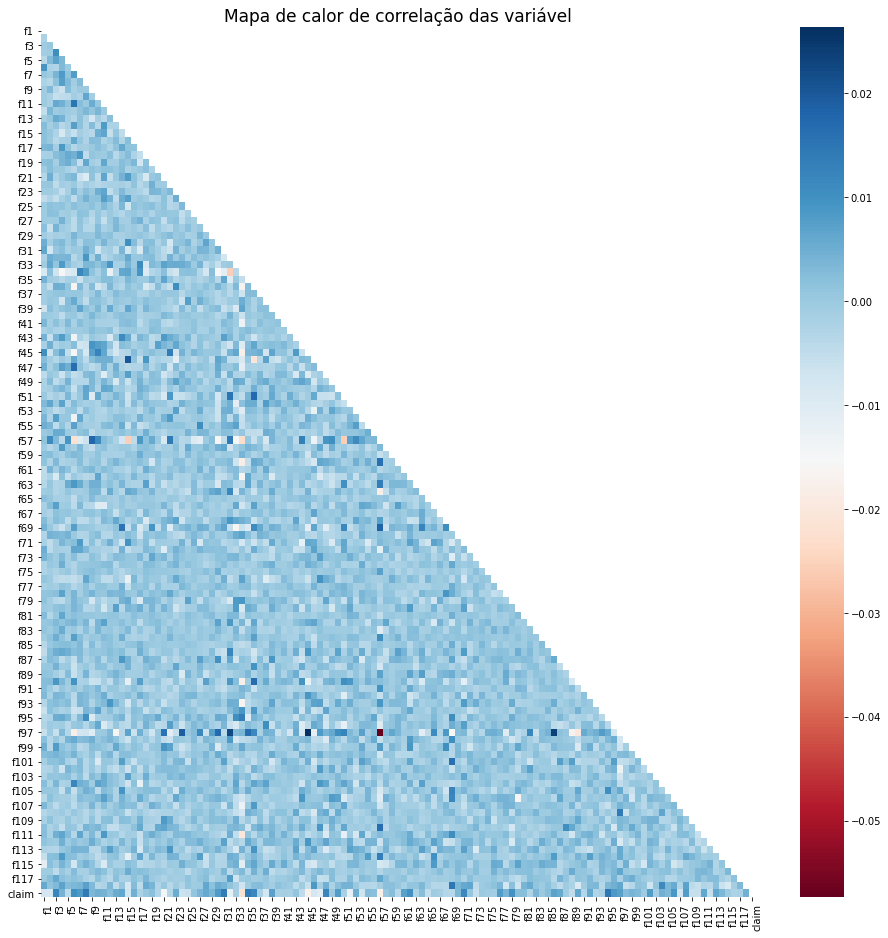

In [91]:
df = df1_train.corr().round(5)

# Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
mask = np.zeros_like(df)
mask[np.triu_indices_from(mask)] = True

# Making a plot
plt.figure(figsize=(16,16))
ax = sns.heatmap(df, annot=False, mask=mask, cmap="RdBu", annot_kws={"weight": "bold", "fontsize":13})

ax.set_title("Mapa de calor de correlação das variável", fontsize=17)

plt.setp(ax.get_xticklabels(), 
         rotation      = 90, 
         ha            = "right",
         rotation_mode = "anchor", 
         weight        = "normal")

plt.setp(ax.get_yticklabels(), 
         weight        = "normal",
         rotation_mode = "anchor", 
         rotation      = 0, 
         ha            = "right");

Como podemos ver, a correlação está entre ~-0,05 e ~0,02, o que é muito pequeno. Portanto, as variáveis são fracamente correlacionados. 

Existem alguns recursos com correlação relativamente baixa com o valor alvo, mesmo em comparação com outros recursos, isso pode sugerir uma exclusão dessas variáveis.

In [92]:
df[(df["claim"]>-0.001) & (df["claim"]<0.001)]["claim"]

f18     0.00032
f26     0.00090
f43     0.00094
f49    -0.00004
f58     0.00024
f66    -0.00048
f72     0.00082
f74     0.00018
f75    -0.00058
f76    -0.00086
f84    -0.00004
f88    -0.00098
f101   -0.00013
f115   -0.00043
Name: claim, dtype: float64

### 1.2.2. Distribuição

#### 1.2.2.1. Target
Vamos ver as ocorrências de números individuais do conjunto de dados de treino.

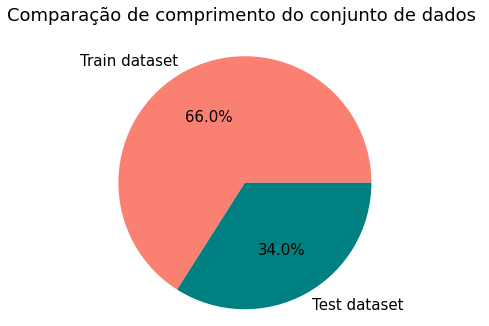

In [93]:
fig, ax = plt.subplots(figsize=(5, 5))

pie = ax.pie([len(df1_train), len(df1_test)],
             labels   = ["Train dataset", "Test dataset"],
             colors   = ["salmon", "teal"],
             textprops= {"fontsize": 15},
             autopct  = '%1.1f%%')
ax.axis("equal")
ax.set_title("Comparação de comprimento do conjunto de dados \n", fontsize=18)
fig.set_facecolor('white')
plt.show();

O número de pessoas que não reclamam e reclamam (0 e 1) é quase igual a 480.404 e 477.515, respectivamente. Em termos de porcentagem, tanto as pessoas que afirmam quanto não afirmam ficam em torno de 50%, neste caso não precisamos tratamento para dados desbalanceados. 

Referência: https://www.kaggle.com/desalegngeb/sept-2021-tps-eda-model

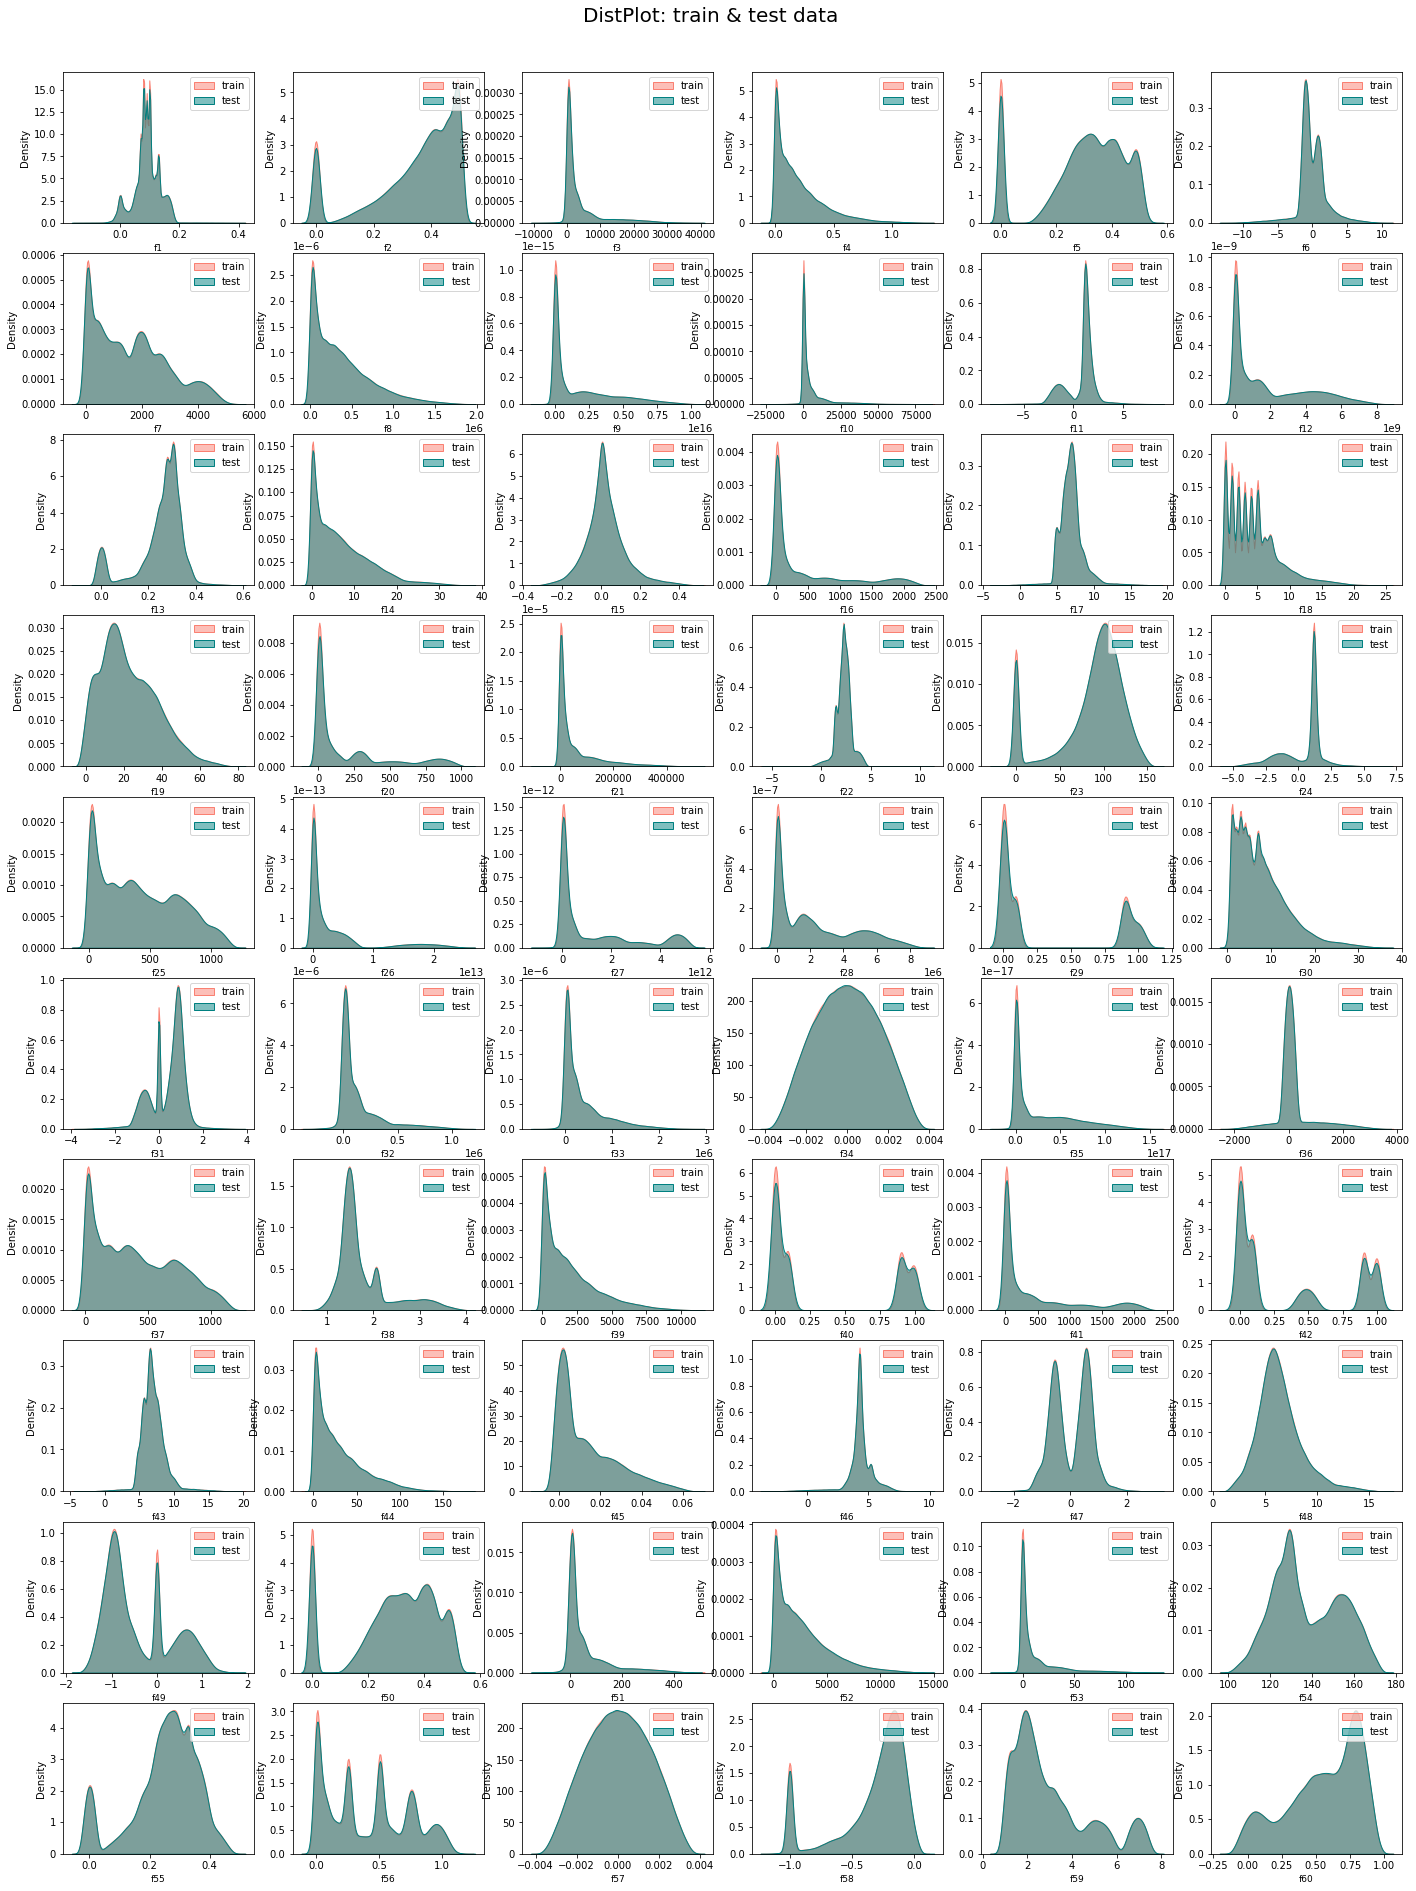

In [26]:
L    = len(df1_train.columns[0:60])
nrow = int(np.ceil(L/6))
ncol = 6

remove_last= (nrow * ncol) - L

fig, ax = plt.subplots(nrow, ncol,figsize=(24, 30))
fig.subplots_adjust(top=0.95)
i = 1

for feature in df1_train.columns[0:60]:
    
    plt.subplot(nrow, ncol, i)
    
    ax = sns.kdeplot(df1_train[feature], shade=True, color='salmon',  alpha=0.5, label='train')
    ax = sns.kdeplot(df1_test[feature], shade=True, color='teal',  alpha=0.5, label='test')
    plt.xlabel(feature, fontsize=9)
    plt.legend()
    
    i += 1
    
plt.suptitle('DistPlot: train & test data', fontsize=20)
plt.show()

**NOTA:**

- Os conjuntos de treinamento e teste têm aproximadamente as mesmas distribuições em termos de variáveis;
- Temos poucas variáveis com distribuições normais;
- A maioria das variáveis tem distribuições distorcidas.

Precisamos pensar em como fazer tudo isso normalmente distribuído se decidirmos usar modelos não baseados em árvore.

> A verificação da correlação não revelou relações significativas entre as características (a maioria estava entre 0,02 e -0,05).


#### 1.2.2. Detecção de Outlier

#### 1.2.2.1. Data Train

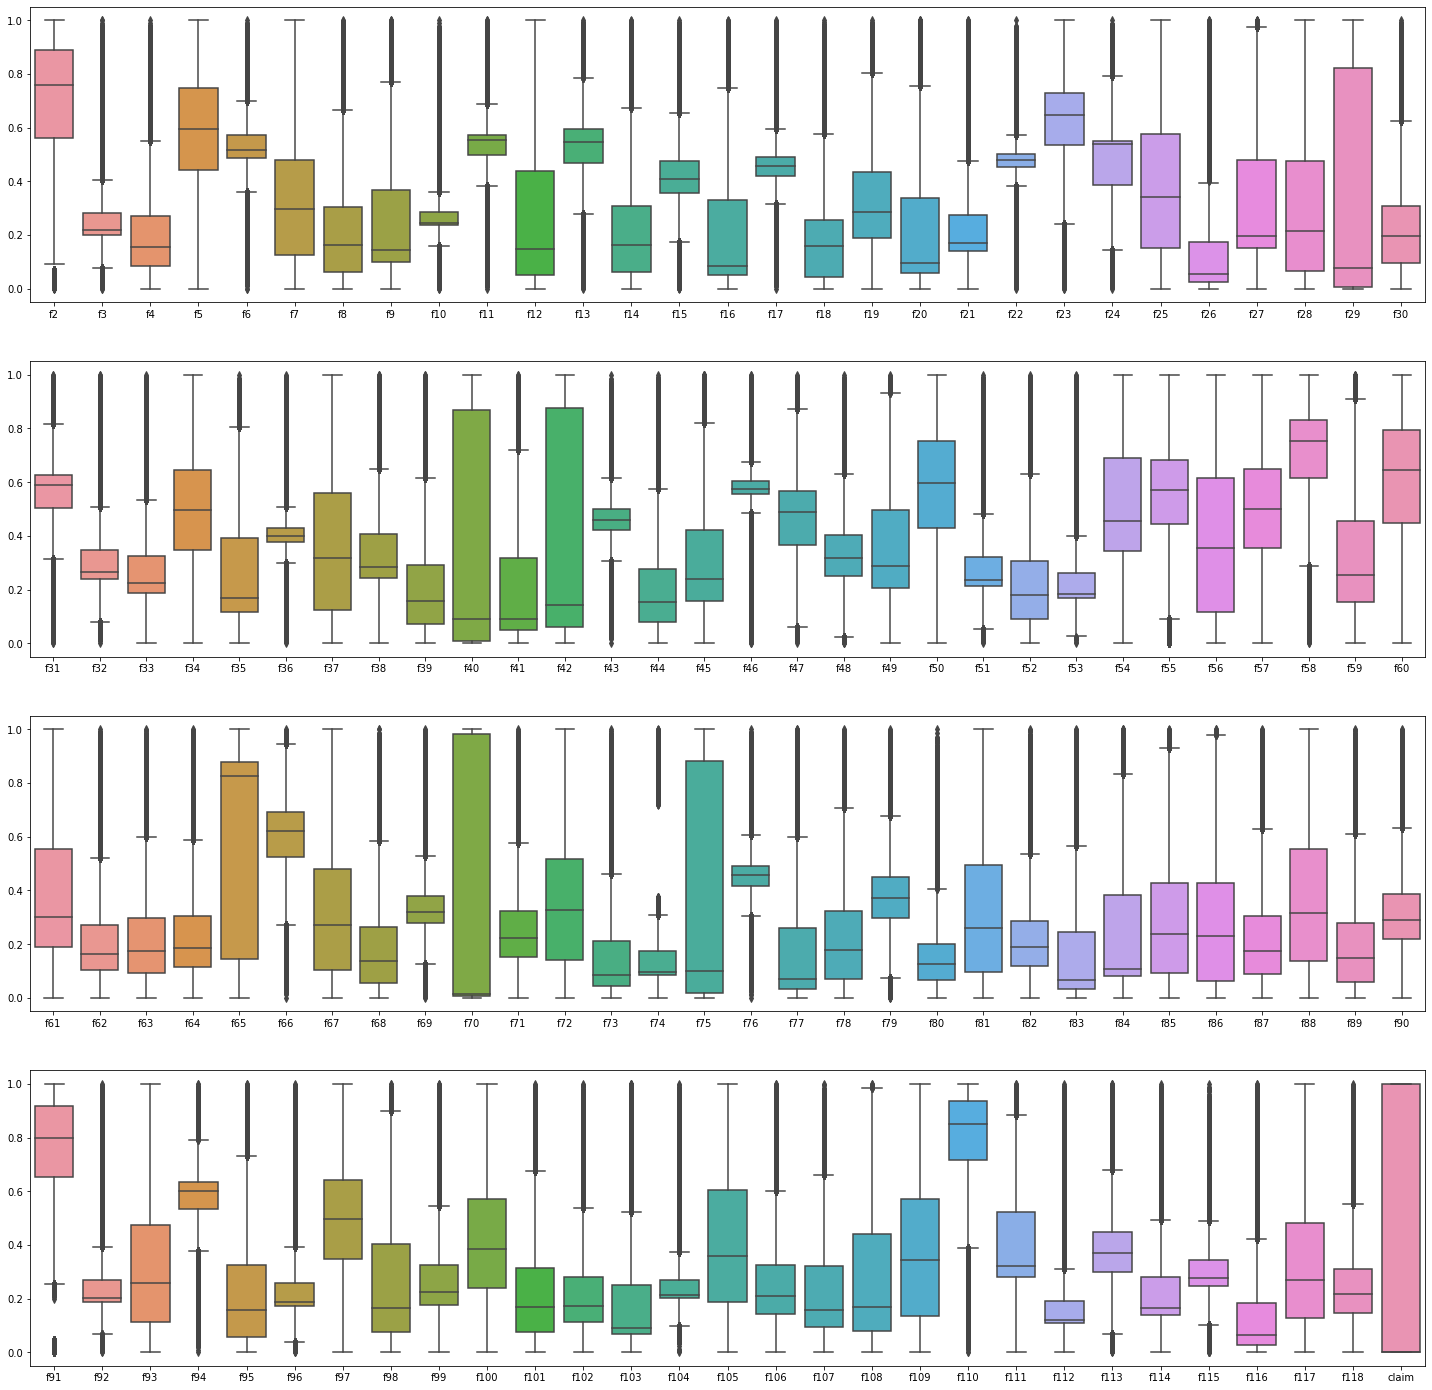

In [95]:
# Reference: https://www.kaggle.com/suharkov/sep-2021-playground-eda-no-model-for-now
df_plot = ((df1_train - df1_train.min())/(df1_train.max() - df1_train.min()))
fig, ax = plt.subplots(4, 1, figsize = (25,25))

for i, (x) in enumerate([(1,30), (30,60), (60,90), (90,120)]): 
    sns.boxplot(data = df_plot.iloc[:, x[0]:x[1] ], ax = ax[i]);

#### 1.2.2.2. Data Test

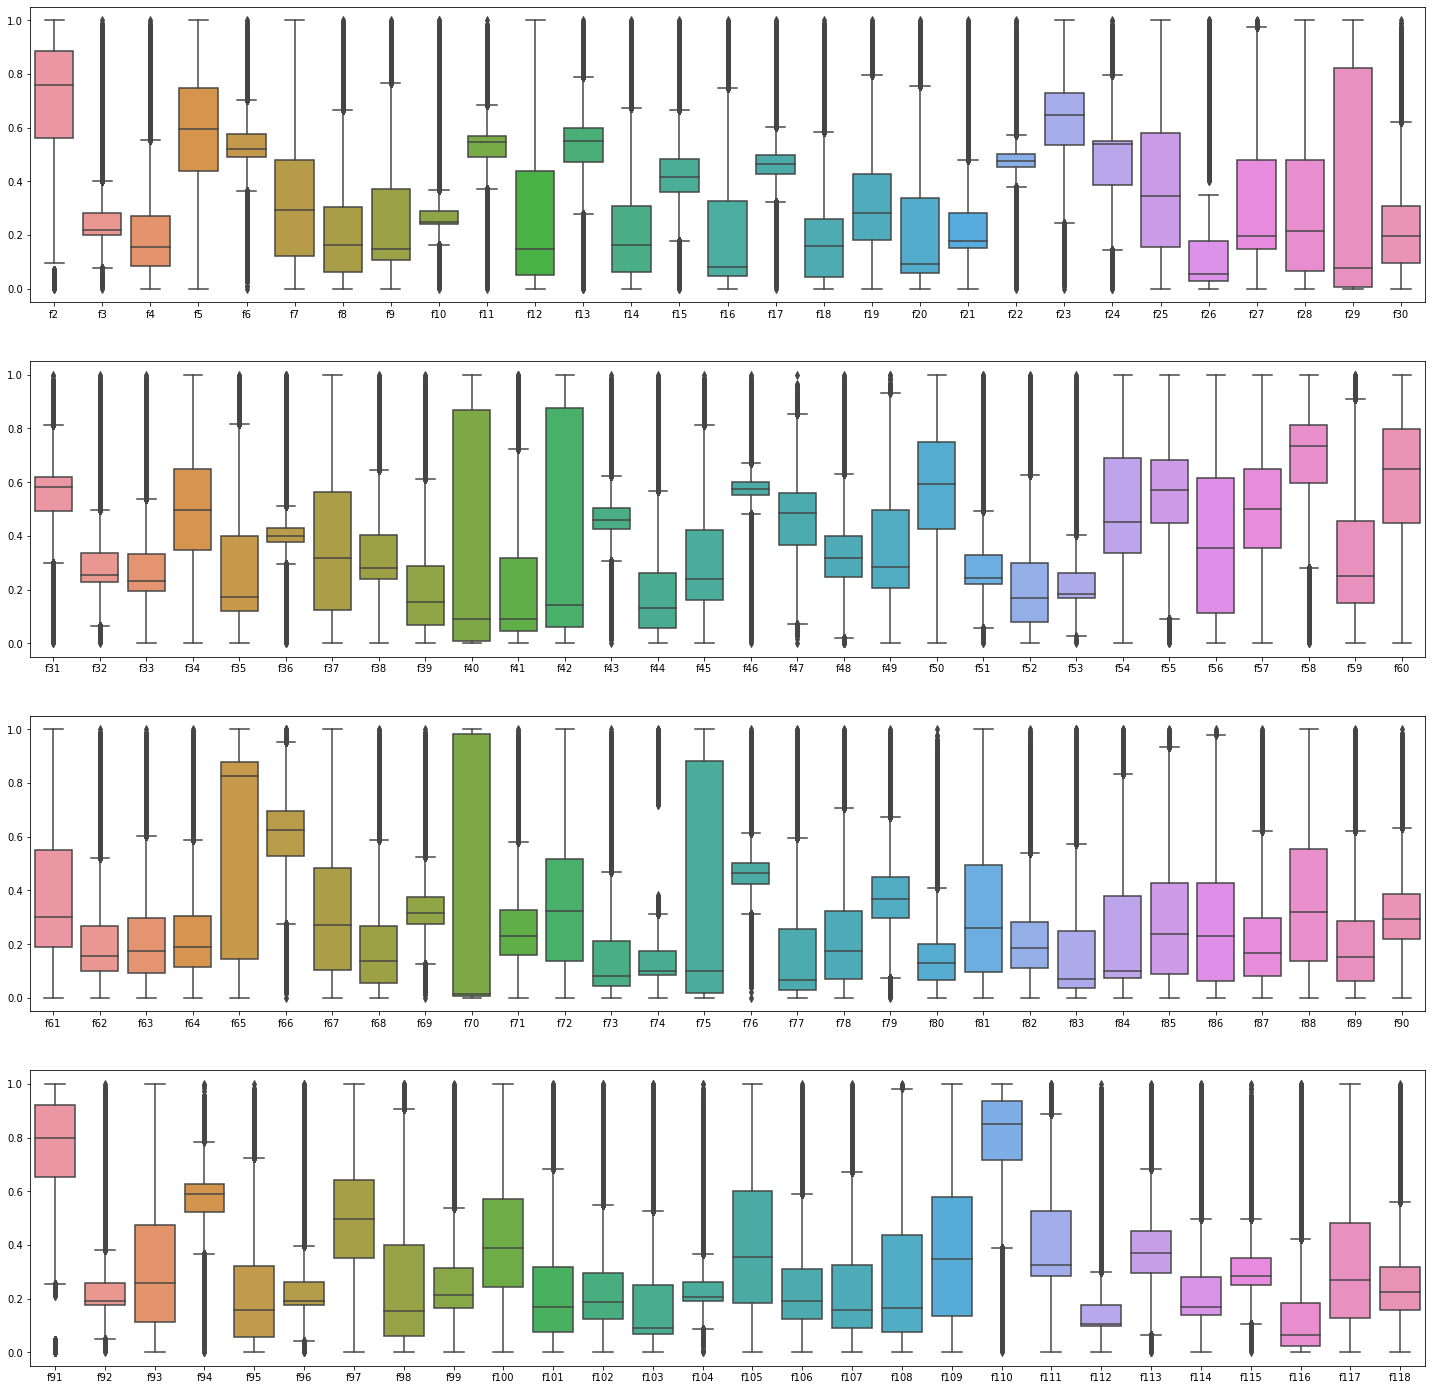

In [96]:
# Reference: https://www.kaggle.com/suharkov/sep-2021-playground-eda-no-model-for-now
df_plot = ((df1_test - df1_test.min())/(df1_test.max() - df1_test.min()))
fig, ax = plt.subplots(4, 1, figsize = (25,25))

for i, (x) in enumerate([(1,30), (30,60), (60,90), (90,120)]): 
    sns.boxplot(data = df_plot.iloc[:, x[0]:x[1] ], ax = ax[i]);

**`NOTA:`**

Acima observamos que temos muitos outliers em ambos conjunto de dados, no processamento vamos trartá-los.

#### 1.2.2.2. Claim
A variável alvo tem um valor de 0 a 1 que indica pessoas que não reclamam e reclamam o seguro. Vamos verificar a distribuição da variável de reclamação (claim).

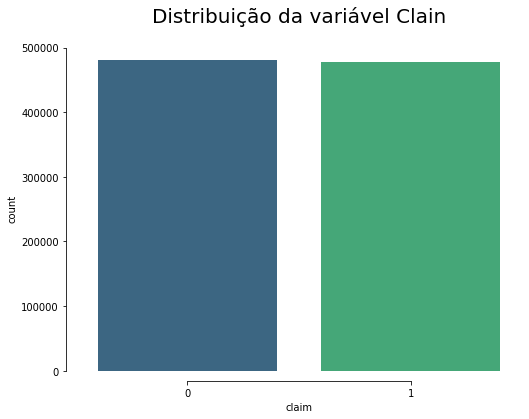

In [98]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x=df1_train['claim'], palette='viridis')
ax.set_title('Distribuição da variável Clain', fontsize=20, y=1.05)

sns.despine(right=True)
sns.despine(offset=10, trim=True)

O número de pessoas que não reclamam e reclamam (0 e 1) é quase igual a 480.404 e 477.515, respectivamente. Em termos de porcentagem, tanto as pessoas que afirmam quanto não afirmam ficam em torno de 50%, neste caso não precisamos tratamento para dados desbalanceados.

#### 1.2.2.3. Variáveis preditoras  vs Target.

Referência: https://www.kaggle.com/desalegngeb/sept-2021-tps-eda-model

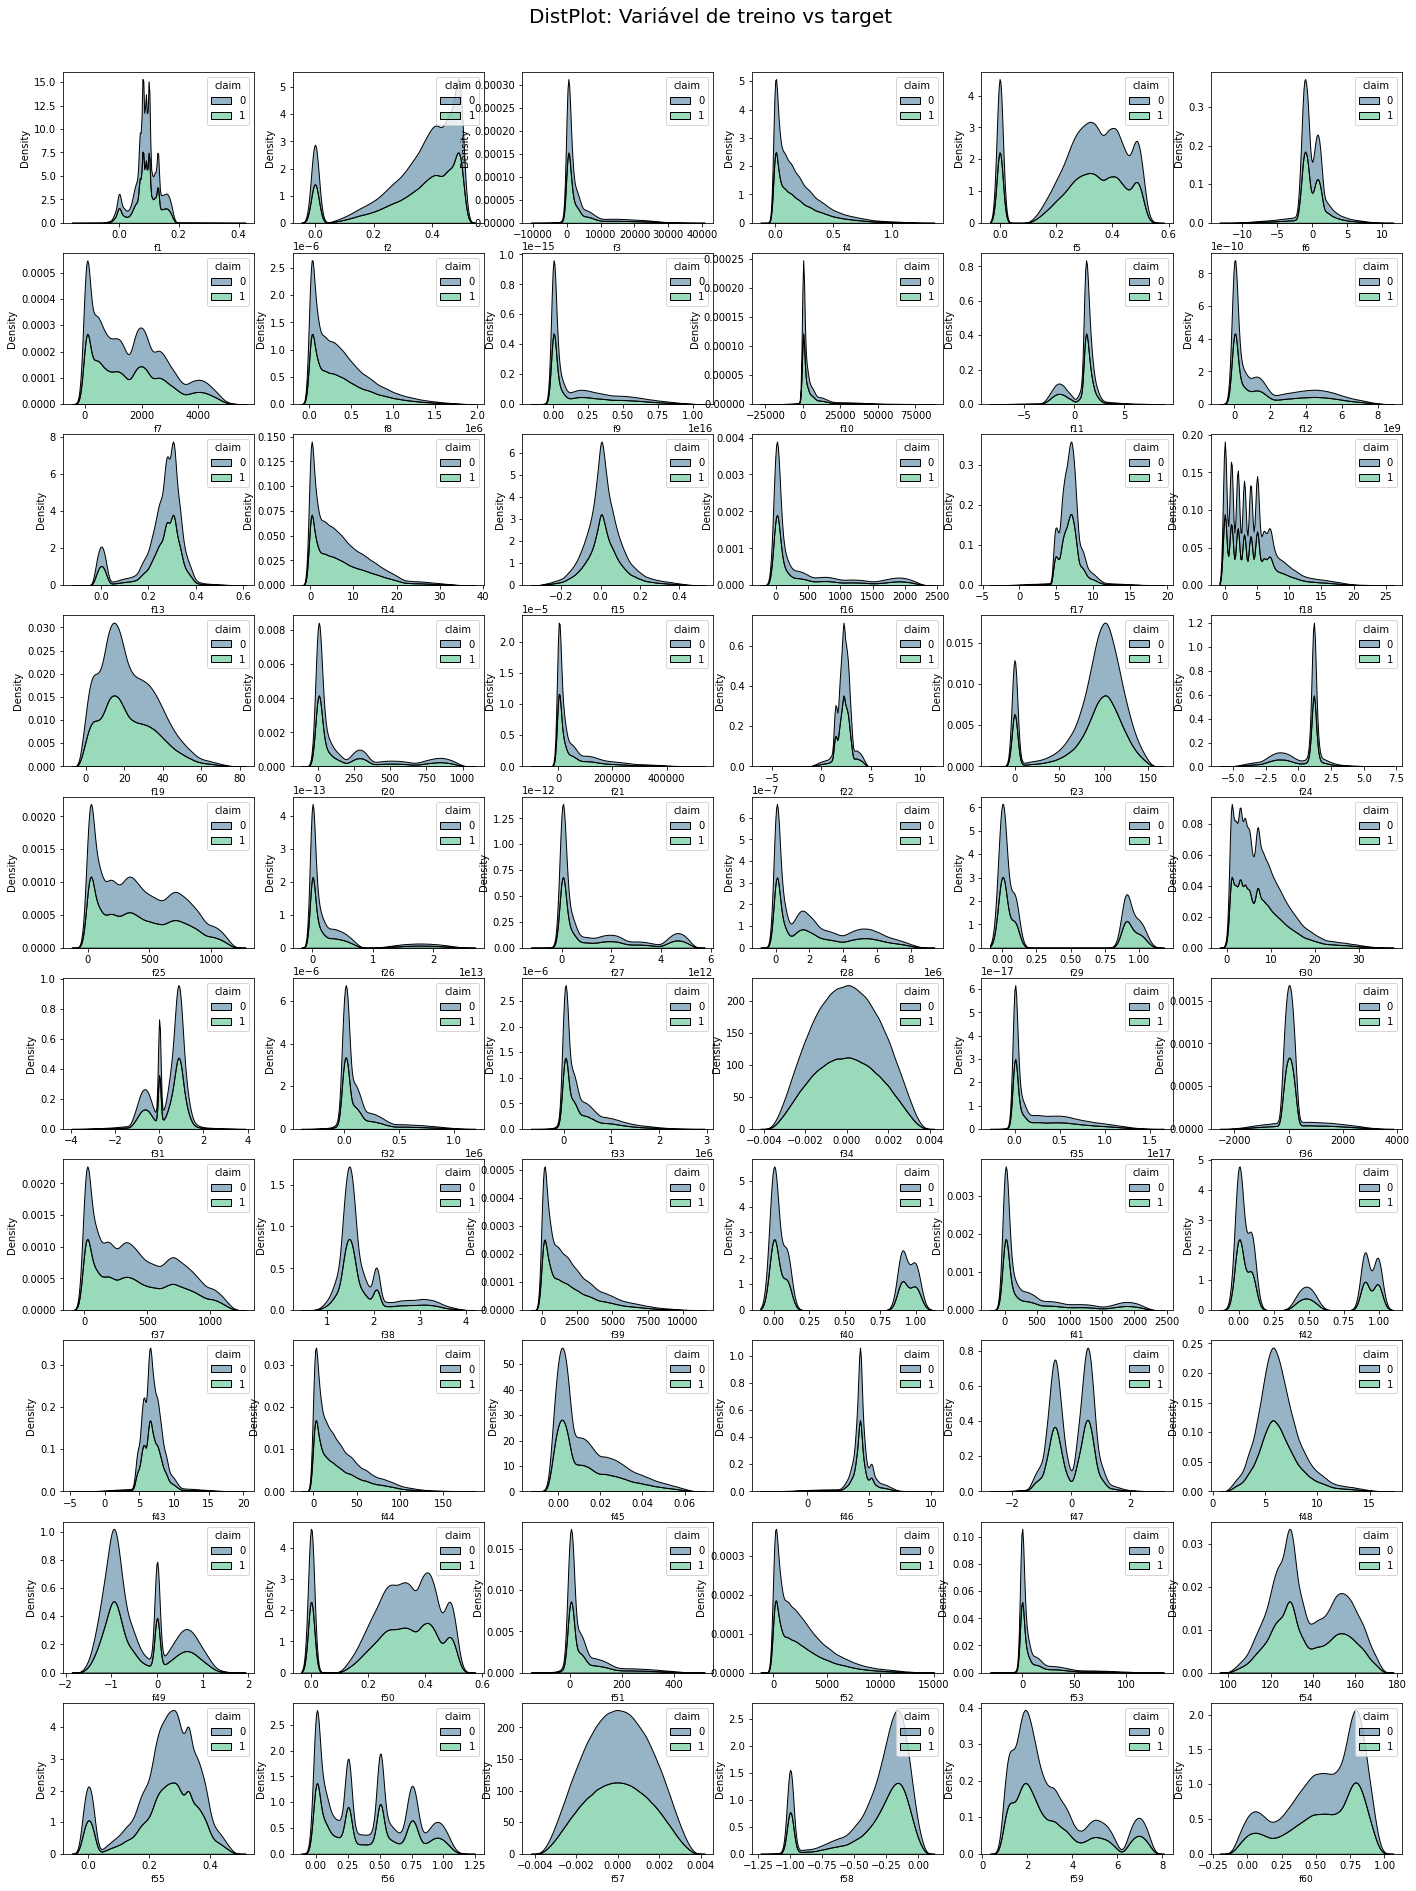

In [28]:
L    = len(df1_train.columns[0:60])
nrow = int(np.ceil(L/6))
ncol = 6
i    = 1
remove_last= (nrow * ncol) - L

fig, ax = plt.subplots(nrow, ncol,figsize=(24, 30))
fig.subplots_adjust(top=0.95)

for feature in df1_train.columns[0:60]:
    
    plt.subplot(nrow, ncol, i)
    
    ax = sns.kdeplot(df1_train[feature], 
                     shade    = True, 
                     palette  = 'viridis',  
                     alpha    = 0.5, 
                     hue      = df1_train['claim'], 
                     multiple = "stack")
    
    plt.xlabel(feature, fontsize=9)
    
    i += 1
    
plt.suptitle('DistPlot: Variável de treino vs target', fontsize=20)
plt.show()
gc.collect()

# <div class="alert alert-success">  2.0. Modelo Baseline XGB </div> 

Nesta etapa, treinaremos nosso modelo XGBClassifier de linha de base simples. Existem valores ausentes em nossos dados, vamos preenchê-los com uma média e dimensionar todos os dados.

In [103]:
X    = df1_train.drop('claim', axis=1)
y    = df1_train['claim']
cols = X.columns

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size    = 0.2,
                                                      shuffle      = True, 
                                                      stratify     = y,
                                                      random_state = 0)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape 

((766335, 118), (766335,), (191584, 118), (191584,))

In [104]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train = pd.DataFrame(imputer.fit_transform(X_train),  columns=cols)
X_valid = pd.DataFrame(imputer.fit_transform(X_valid),  columns=cols)
X_test  = pd.DataFrame(imputer.fit_transform(df1_test),  columns=cols)

In [106]:
X_test.head()

In [113]:
params = {'random_state': 0,
          'predictor'   : 'gpu_predictor',
          'tree_method' : 'gpu_hist',
          'eval_metric' : 'auc'}

model_baseline = xgb.XGBClassifier(**params)

scalers = [None, StandardScaler(), RobustScaler(), MinMaxScaler(), 
           MaxAbsScaler(), QuantileTransformer(output_distribution='normal', random_state=0)]

for scaler in scalers: 
    
    if scaler!=None:
        X_train_s = scaler.fit_transform(X_train)
        X_valid_s = scaler.fit_transform(X_valid)
    else:
        X_train_s = X_train
        X_valid_s = X_valid
                
    model_baseline.fit(X_train_s, y_train, verbose = False)
    y_hat = model_baseline.predict_proba(X_valid_s)[:, 1]
    
    fpr, tpr, thresholds = metrics.roc_curve(y_valid, y_hat)
    
    auc = metrics.auc(fpr, tpr)
    print('Validaçao AUC: {:2.5f} => {}'.format(auc, scaler))

Validaçao AUC: 0.61330 => None
Validaçao AUC: 0.73511 => StandardScaler()
Validaçao AUC: 0.63096 => RobustScaler()
Validaçao AUC: 0.57664 => MinMaxScaler()
Validaçao AUC: 0.60448 => MaxAbsScaler()
Validaçao AUC: 0.73602 => QuantileTransformer(output_distribution='normal', random_state=0)


Com scaler StandarScaler obtivemos uma AUC de `0.73511`, vamos fazer uma validação cruzada com as normalizações.

In [114]:
%%time

gc.collect()

scalers = [None, StandardScaler(), RobustScaler(), MinMaxScaler(), 
           MaxAbsScaler(), QuantileTransformer(output_distribution='normal', random_state=0)]

for scaler in scalers: 

    FOLDS               = 5
    df_submission.claim = 0
    auc                 = []
    lloss               = []
    f1                  = []

    kfold               = KFold(n_splits = FOLDS, random_state = 0, shuffle = True)
    
    if scaler!=None:
        X_ts = scaler.fit_transform(X_test.copy())
    else:
        X_ts = X_test.copy()

    print('='*80)
    print('Scaler: {}'.format(scaler))
    print('='*80)

    for i, (train_idx, test_idx) in enumerate(kfold.split(X_train)):

        i+=1
        
        X_tr, y_tr = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_vl, y_vl = X_train.iloc[test_idx], y_train.iloc[test_idx]

        # Scaler
        if scaler!=None:    
            X_tr = scaler.fit_transform(X_tr)
            X_vl = scaler.fit_transform(X_vl)                

        model = xgb.XGBClassifier(**params)

        model.fit(X_tr, y_tr)

        y_hat_prob = model.predict_proba(X_vl)[:, 1]
        y_hat      = (y_hat_prob >.5).astype(int) 
        
        fpr, tpr, thresholds = metrics.roc_curve(y_vl, y_hat_prob)
                 
        log_loss_     = metrics.log_loss(y_vl, y_hat_prob)                
        f1_score_     = metrics.f1_score(y_vl, y_hat)        
        auc_          = metrics.auc(fpr, tpr)    
                
        print('[Fold {}] AUC: {:.5f} - F1: {:.5f} - L. LOSS: {:.5f}'.format(i, auc_, f1_score_, log_loss_))

        df_submission.claim += model.predict_proba(X_ts)[:, 1] / FOLDS

        f1.append(f1_score_)
        lloss.append(log_loss_)
        auc.append(auc_)

    
    auc_mean   = np.mean(auc)
    auc_std    = np.std(auc)
    lloss_mean = np.mean(lloss)
    f1_mean    = np.mean(f1)
    
    print('-'*80)
    print('[Mean Fold] AUC: {:.5f}(Std:{:.5f}) - F1: {:.5f} - L. LOSS: {:.5f}'.format(auc_mean,
                                                                                      auc_std,
                                                                                      f1_mean, 
                                                                                      lloss_mean))
    print('='*80)
    print('')
    
    # Gerar o arquivo de submissão 
    name_file_submission = '001_xgb_submission_baseline_' + str(scaler).lower()[:4] + '.csv'
    df_submission.to_csv(name_file_submission, index = False)
    
    #gc.collect()

Scaler: None
[Fold 1] AUC: 0.77545 - F1: 0.69752 - L. LOSS: 0.59507
[Fold 2] AUC: 0.77671 - F1: 0.69742 - L. LOSS: 0.59382
[Fold 3] AUC: 0.77640 - F1: 0.69695 - L. LOSS: 0.59388
[Fold 4] AUC: 0.77607 - F1: 0.69773 - L. LOSS: 0.59368
[Fold 5] AUC: 0.77638 - F1: 0.69654 - L. LOSS: 0.59382
------------------------------------------------------------
[Mean Fold] AUC: 0.77620 - F1: 0.69654 - L. LOSS: 0.59406

Scaler: StandardScaler()
[Fold 1] AUC: 0.61566 - F1: 0.15970 - L. LOSS: 0.70771
[Fold 2] AUC: 0.61957 - F1: 0.16448 - L. LOSS: 0.70867
[Fold 3] AUC: 0.61251 - F1: 0.14727 - L. LOSS: 0.71231
[Fold 4] AUC: 0.61762 - F1: 0.17281 - L. LOSS: 0.70625
[Fold 5] AUC: 0.61505 - F1: 0.13032 - L. LOSS: 0.71100
------------------------------------------------------------
[Mean Fold] AUC: 0.61608 - F1: 0.13032 - L. LOSS: 0.70919

Scaler: RobustScaler()
[Fold 1] AUC: 0.62015 - F1: 0.16395 - L. LOSS: 0.70875
[Fold 2] AUC: 0.62729 - F1: 0.18809 - L. LOSS: 0.70334
[Fold 3] AUC: 0.62021 - F1: 0.17588 - L

<div class="alert alert-info" role="alert">

Na validação cruzada obtivemos uma `AUC` de `0.77727` com um desvio padrão de `0.00149` sem fazer o scaler, vamos gerar um arquivo para submissão. 
    
    
**Nota:**
   
Na validação cruzada que foi realizada, mostra que não fazer a normalização temos a melhor AUC, porém abaixo podemos observar que a melhor scaler na submissão foi de 0.69320 com a StanderScaler, abaixo um resumo:        
- AUC: 0.64631 => Sem normalização 
- AUC: 0.67258 => RobustScaler 
- AUC: 0.69320 => StanderScaler 
- AUC: 0.60872 => MinMaxScaler 
- AUC: 0.63037 => MaxAbsScaler 
      
Acrescentei na validação o scaler QuantileTransformer que teve uma AUC de 0.72080, batendo o StanderScaler na validação e o no kaggle com AUC de `0.74479` que é melhor que a validação realizada neste notebook.
    

In [ ]:
def objective(trial, X, y):

    param_grid = {
    #"device_type"       : trial.suggest_categorical("device_type", ['gpu']),
    "n_estimators"      : trial.suggest_categorical("n_estimators", [10000]),
    "learning_rate"     : trial.suggest_float("learning_rate", 0.01, 0.3),
    "num_leaves"        : trial.suggest_int("num_leaves", 20, 3000, step=20),
    "max_depth"         : trial.suggest_int("max_depth", 3, 12),
    "min_data_in_leaf"  : trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
    "max_bin"           : trial.suggest_int("max_bin", 200, 300),
    "lambda_l1"         : trial.suggest_int("lambda_l1", 0, 100, step=5),
    "lambda_l2"         : trial.suggest_int("lambda_l2", 0, 100, step=5),
    "min_gain_to_split" : trial.suggest_float("min_gain_to_split", 0, 15),
    "bagging_fraction"  : trial.suggest_float("bagging_fraction", 0.2, 0.95, step=0.1),
    "bagging_freq"      : trial.suggest_categorical("bagging_freq", [1]),
    "feature_fraction"  : trial.suggest_float("feature_fraction", 0.2, 0.95, step=0.1),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)
    
    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = lgbm.LGBMClassifier(objective="binary", **param_grid)
        
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="binary_logloss",
            early_stopping_rounds=100,
            callbacks=[
            LightGBMPruningCallback(trial, "binary_logloss")
            ],  # Add a pruning callback
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)